In [2]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle

In [3]:
class Level2(Client):
    global file
    num_updates = 0
      
    # Receives message from API websocket
    def on_message(self, message):
        # Get snapshot of LOB from API and build internal representation
        if message['type'] == 'snapshot':
            self.starting_time = datetime.datetime.now(datetime.timezone.utc)
            print('Starting time: {}'.format(self.starting_time))
            print()
            pickle.dump([datetime.datetime.now(datetime.timezone.utc), message['bids'], message['asks']],file)

            
        # Update order book when new event occurs
        if message['type'] == 'l2update' and 'time' in message:
            for (side, price, amount) in message['changes']:
                pickle.dump({
                    "side": side, \
                    "price": price, \
                    "amount": amount, \
                    "time": message['time']      
                },file)
                self.num_updates += 1
                if self.num_updates % 500 == 0:
                    print("Number of updates: {}".format(self.num_updates))
                    print("Most Recent Update: {}".format((side, price, amount)))
                    print("Time: {}".format(message['time']))
                    print()
            

file = open("12_25_18_data.pkl","wb")
loop = asyncio.get_event_loop()
channel = Channel('level2', 'ETC-USD')
ws = Level2(loop, channel)

async def my_task(seconds):
    global loop
    print('Collecting data for {} seconds'.format(seconds))
    await asyncio.sleep(seconds)
    await ws.close()
    return "Finished Task"

try:
    task_obj = loop.create_task(my_task(seconds=86400))
    loop.run_until_complete(task_obj)
finally:
    loop.close()
    file.close()
    print("Finished collecting data")

Starting time: 2018-12-25 04:37:09.198860+00:00

Number of updates: 500
Most Recent Update: ('sell', '4.70000000', '354.03')
Time: 2018-12-25T04:39:22.362Z

Number of updates: 1000
Most Recent Update: ('buy', '4.54000000', '398.1242')
Time: 2018-12-25T04:42:09.027Z

Number of updates: 1500
Most Recent Update: ('sell', '4.57000000', '200.99858931')
Time: 2018-12-25T04:44:26.417Z

Number of updates: 2000
Most Recent Update: ('sell', '4.61000000', '6086.30263209')
Time: 2018-12-25T04:45:54.925Z

Number of updates: 2500
Most Recent Update: ('sell', '4.65000000', '513.43')
Time: 2018-12-25T04:48:17.794Z

Number of updates: 3000
Most Recent Update: ('buy', '4.56000000', '1563.19851974')
Time: 2018-12-25T04:50:55.799Z

Number of updates: 3500
Most Recent Update: ('buy', '4.55000000', '5607.12773839')
Time: 2018-12-25T04:54:06.478Z

Number of updates: 4000
Most Recent Update: ('sell', '4.60000000', '2271.84735003')
Time: 2018-12-25T04:56:24.715Z

Number of updates: 4500
Most Recent Update: ('b

KeyboardInterrupt: 

In [6]:
def parse_file(file_name):
    raw_updates = []
    with open(file_name,"rb") as f:
        starting_time,starting_bids,starting_asks = list(pickle.load(f))
        while True:
            try:
                raw_updates.append(pickle.load(f))
            except EOFError:
                break
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if amount == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if amount == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    
    return(starting_time, updates)

parsed_file = parse_file("12_25_18_data.pkl")
len(parsed_file[1])

28870

In [11]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

starting_time,updates = shortened_updates('12_25_18_data.pkl',10)
len(updates)

27922

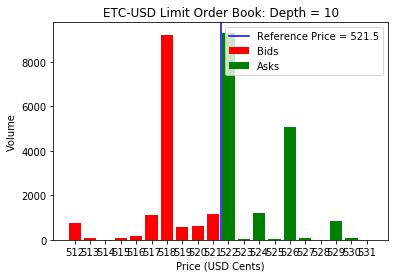

Reference Price: 521.5
---------------------------------------
First 10 Bids: 
512, 776.081517
513, 74.10412418
514, 11.10412418
515, 70.02127545
516, 170.11930341
517, 1119.36157058
518, 9222.41795367
519, 581.03998861
520, 623.5484617
521, 1164.5715
---------------------------------------
First 10 Asks: 
522, 9310.03039851
523, 17.24416952
524, 1215.98995632
525, 14.58923458
526, 5060.72725726
527, 91.3098
528, 10.1
529, 841.34968876
530, 61.44
531, 13.11222914
---------------------------------------




In [14]:
# Displays Order Book
def display_order_book(bids, asks, K, reference_price=None):
    if reference_price == None:
        sorted_bids = list(reversed(sorted(bids.items())))
        sorted_asks = list(sorted(asks.items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            reference_price = round((best_bid+best_ask+1)/2, 1)
        
    bids = bids.items()
    bids = [b for b in bids if (reference_price - b[0]) < K]
    bid_prices = [b[0] for b in bids]
    bid_volumes = [b[1] for b in bids]

    asks = asks.items()
    asks = [a for a in asks if (a[0] - reference_price) < K]
    ask_prices = [a[0] for a in asks]
    ask_volumes = [a[1] for a in asks]

    b1 = plt.bar(bid_prices, bid_volumes, color='r')
    b2 = plt.bar(ask_prices, ask_volumes, color='g')
    v = plt.axvline(x=reference_price, color='b')
    plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])

    plt.title('ETC-USD Limit Order Book: Depth = {}'.format(K))
    plt.legend(['Reference Price = {}'.format(reference_price), 'Bids', 'Asks'])
    plt.xlabel('Price (USD Cents)')
    plt.ylabel('Volume')
    plt.show()

# Prints LOB
def print_order_book(bids, asks, K, reference_price=None):
    if reference_price == None:
        sorted_bids = list(reversed(sorted(bids.items())))
        sorted_asks = list(sorted(asks.items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            reference_price = round((best_bid+best_ask+1)/2, 1)
        
    first_bid = int(round(reference_price - 0.5))
    first_ask = int(round(reference_price + 0.5))      
    
    print("Reference Price: {}".format(reference_price))
    print("---------------------------------------")

    print("First {} Bids: ".format(K))
    for price in range(first_bid - K + 1, first_bid + 1):
        print("{}, {}".format(price, bids.get(price, 0)))
    print("---------------------------------------")

    print("First {} Asks: ".format(K))
    for price in range(first_ask, first_ask + K):
        print("{}, {}".format(price, asks.get(price, 0)))
    print("---------------------------------------")
    print("\n")
    
display_order_book(parsed_file[1][0]['Bids'],parsed_file[1][0]['Asks'],10)
print_order_book(parsed_file[1][0]['Bids'],parsed_file[1][0]['Asks'],10)

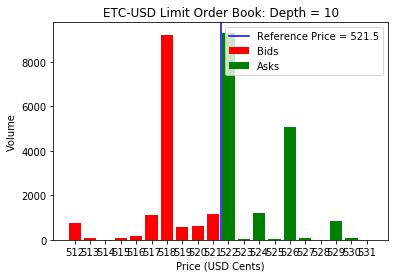

Reference Price: 521.5
---------------------------------------
First 10 Bids: 
512, 776.081517
513, 74.10412418
514, 11.10412418
515, 70.02127545
516, 170.11930341
517, 1119.36157058
518, 9222.41795367
519, 581.03998861
520, 623.5484617
521, 1164.5715
---------------------------------------
First 10 Asks: 
522, 9310.03039851
523, 17.24416952
524, 1215.98995632
525, 14.58923458
526, 5060.72725726
527, 91.3098
528, 10.1
529, 841.34968876
530, 61.44
531, 13.11222914
---------------------------------------




In [16]:
# Displays Order Book
def display_order_book_shortened(shortened_book, reference_price):    
    K = list(shortened_book.keys())[-1]
    bid_prices = [int(round(x[0] + reference_price + 0.5)) for x in shortened_book.items() if x[0] < 0]
    bid_volumes = [x[1] for x in shortened_book.items() if x[0] < 0]

    ask_prices = [int(round(x[0] + reference_price - 0.5)) for x in shortened_book.items() if x[0] > 0]
    ask_volumes = [x[1] for x in shortened_book.items() if x[0] > 0]

    b1 = plt.bar(bid_prices, bid_volumes, color='r')
    b2 = plt.bar(ask_prices, ask_volumes, color='g')
    v = plt.axvline(x=reference_price, color='b')
    plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])

    plt.title('ETC-USD Limit Order Book: Depth = {}'.format(K))
    plt.legend(['Reference Price = {}'.format(reference_price), 'Bids', 'Asks'])
    plt.xlabel('Price (USD Cents)')
    plt.ylabel('Volume')
    plt.show()
    
def print_order_book_shortened(shortened_book, reference_price):      
    first_bid = int(round(reference_price - 0.5))
    first_ask = int(round(reference_price + 0.5))  
    K = list(shortened_book.keys())[-1]

    print("Reference Price: {}".format(reference_price))
    print("---------------------------------------")

    print("First {} Bids: ".format(K))
    for k in range(-K, 0):
        price = int(round(k + reference_price + 0.5))
        print("{}, {}".format(price, shortened_book[k]))
    print("---------------------------------------")

    print("First {} Asks: ".format(K))
    for k in range(1, K+1):
        price = int(round(k + reference_price - 0.5))
        print("{}, {}".format(price, shortened_book[k]))
    print("---------------------------------------")
    print("\n")    
    
display_order_book_shortened(updates[0]['LOB'],updates[0]['reference_price'])
print_order_book_shortened(updates[0]['LOB'],updates[0]['reference_price'])